# Predicting NBA Game Outcomes Using Elo Ratings

## Goal: 
The objective of this project is to predict both NBA regular season and playoff game outcomes based on teams' elo ratings, shooting percentages, and other statistics.

### Introduction: 
The fivethirtyeight.com website uses elo ratings to measure a team's strength throughout the regular season and playoffs. Depending on the final score of a game, the location of a game (home or away), and the elo ratings of the two teams entering a game, each team's elo rating changes after every game they play.  Furthermore, elo ratings are posited as more accurate than W-L records in assessing a team's strength.  Although fivethirtyeight does not explicitly define the formula it uses to calculate elo ratings, the general equation for elo ratings is defined here:

$E_0=1300$

$E_{i+1}=K(S_{team}-\frac{1}{1+10^{\frac{E_{i,opp}-E_i}{400}}})+E_i$

The $E_0$ term is a team's first elo rating, $E_{i+1}$ is a team's elo rating after a game, $E_i$ is a team's rating before a game, and $E_{i,opp}$ is the team's opponent's elo rating before the game.  Furthermore, K takes into account the winner of the game, the margin of victory, the location of the game, and the elo ratings of both teams before the game.  Please see the following two articles for more detailed explanations of NBA elo ratings:

- https://www.ergosum.co/nate-silvers-nba-elo-algorithm/
- https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/

The following Toward Data Science article is the inspiration for this project: https://towardsdatascience.com/predicting-the-outcome-of-nba-games-with-machine-learning-a810bb768f20
Although the objective of this project is the same as the objective the Toward Data Science project, the methodology of this project is different in that it uses data from a different timespan, slightly different NBA statistics, and different machine learning models.  As the Toward Data Science article above notes, other data scientists have attempted to predict NBA game outcomes.  Most of their models had an accuracy between 62% and 72%, and for a single season one model predicted playoff games with an accuracy of 74.4% (see first link below).  While most of these projects aim to maximize the overall accuracy metric, my project aims to maximize the AUC metric.  As we discuss in a later section, the AUC metric presents a better assessment of a model than the overall accuracy metric, because AUC measures a model's ability to predict both home team wins and away team wins.  A model may have a high overall accuracy but have little skill at predicting away team wins, for example.  We focus on maximizing AUC instead of overall accuracy to avoid this shortcoming, but we will still compare the overall accuracy of our models to the models used in the articles below:

- https://www.researchgate.net/publication/312236952_Predicting_the_Outcome_of_NBA_Playoffs_Based_on_the_Maximum_Entropy_Principle
- https://library.ndsu.edu/ir/bitstream/handle/10365/28084/Predicting%20Outcomes%20of%20NBA%20Basketball%20Games.pdf?sequence=1&isAllowed=y
- https://towardsdatascience.com/building-my-first-machine-learning-model-nba-prediction-algorithm-dee5c5bc4cc1

### Project Sections
1. Import Packages
2. Clean Data
3. Explore Data with Visualizations
4. Train and Test Machine Learning Models
    

### Data
- Fivethirtyeight elo ratings data downloaded from https://www.kaggle.com/datasets/fivethirtyeight/fivethirtyeight-nba-elo-dataset
    - nbaallelo.csv
- NBA game statistics data downloaded from https://www.kaggle.com/datasets/nathanlauga/nba-games
    - games.csv
    - games_details.csv
- We analyze data from the past 5 seasons: 2010-2011, 2011-2012, 2012-2013, 2013-2014, 2014-2015

### 1. Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.model_selection import GridSearchCV

### 2. Clean Data

In [2]:
# Read in the 3 data sets
nba_games = pd.read_csv('games.csv')
nba_elo = pd.read_csv('nbaallelo.csv')
team_names = pd.read_csv('games_details.csv')

# Drop duplicate rows, drop unnecessary columns
team_names1 = team_names[['TEAM_ID','TEAM_ABBREVIATION','TEAM_CITY']].drop_duplicates(subset='TEAM_ID').reset_index(drop=True)
team_names2 = team_names1.rename(columns={'TEAM_ID':'HOME_TEAM_ID'})

In [3]:
# 2014-2015 season
# Verifying that there are 2 of each game_id - one for the home team's perspective and one for the away team's perspective
(nba_elo[(nba_elo['year_id']==2015)]['game_id'].value_counts() != 2).sum()
# Number of games in 2014-2015 season including playoffs is 2622/2=1311
nba_elo[(nba_elo['year_id']==2015)].shape
# 2013-2014 season
(nba_elo[(nba_elo['year_id']==2014)]['game_id'].value_counts() != 2).sum()
# Number of games in 2013-2014 season including playoffs is 2638/2=1319
nba_elo[(nba_elo['year_id']==2014)].shape
# 2012-2013 season
(nba_elo[(nba_elo['year_id']==2013)]['game_id'].value_counts() != 2).sum()
# Number of games in 2012-2013 season including playoffs is 2628/2=1314
nba_elo[(nba_elo['year_id']==2013)].shape
# 2011-2012 season
(nba_elo[(nba_elo['year_id']==2012)]['game_id'].value_counts() != 2).sum()
# Number of games in 2012-2013 season including playoffs is 2148/2=1074
nba_elo[(nba_elo['year_id']==2012)].shape
# 2010-2011 season
(nba_elo[(nba_elo['year_id']==2011)]['game_id'].value_counts() != 2).sum()
# Number of games in 2010-2011 season including playoffs is 2622/2=1311
nba_elo[(nba_elo['year_id']==2011)].shape

# Create subset of all games played from 2010-2011 season to 2014-2015 season
nba_elo1 = nba_elo[(nba_elo['year_id']==2011) | (nba_elo['year_id']==2012) | 
                   (nba_elo['year_id']==2013) | (nba_elo['year_id']==2014) |
                   (nba_elo['year_id']==2015)].reset_index(drop=True)

In [4]:
# Create a column that indicates whether the team_id is for the home team or away team
nba_elo1['home'] = nba_elo1.apply(lambda x: 'H' if re.search(x['team_id'],x['game_id']) else 'A',axis=1)

In [5]:
nba_elo1['date_object_game'] = nba_elo1['date_game'].apply(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y'))

In [6]:
# We update the date_game column to represent dates like 5/10/2014 as 05/10/2014
nba_elo1['date_game'] = nba_elo1['date_object_game'].apply(lambda x: datetime.datetime.strftime(x,'%m/%d/%Y'))

In [7]:
# Create datetime object
nba_games['DATE_OBJECT_GAME_DATE_EST'] = nba_games['GAME_DATE_EST'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

In [8]:
# Number of games in 2014-2015 season
games_14_15 = nba_games[(nba_games['DATE_OBJECT_GAME_DATE_EST'] >= datetime.datetime(2014,10,28)) & (nba_games['DATE_OBJECT_GAME_DATE_EST'] <= datetime.datetime(2015,6,16))].reset_index(drop=True)
print(str(games_14_15.shape[0]) + ' games in 2014-2015 season')
# Number of games in 2013-2014 season
games_13_14 = nba_games[(nba_games['DATE_OBJECT_GAME_DATE_EST'] >= datetime.datetime(2013,10,29)) & (nba_games['DATE_OBJECT_GAME_DATE_EST'] <= datetime.datetime(2014,6,15))].reset_index(drop=True)
print(str(games_13_14.shape[0]) + ' games in 2013-2014 season')
# Number of games in the 2012-2013 season
games_12_13 = nba_games[(nba_games['DATE_OBJECT_GAME_DATE_EST'] >= datetime.datetime(2012,10,30)) & (nba_games['DATE_OBJECT_GAME_DATE_EST'] <= datetime.datetime(2013,6,20))].reset_index(drop=True)
print(str(games_12_13.shape[0]) + ' games in 2012-2013 season')
# Number of games in the 2011-2012 season
games_11_12 = nba_games[(nba_games['DATE_OBJECT_GAME_DATE_EST'] >= datetime.datetime(2011,12,25)) & (nba_games['DATE_OBJECT_GAME_DATE_EST'] <= datetime.datetime(2012,6,21))].reset_index(drop=True)
print(str(games_11_12.shape[0]) + ' games in 2011-2012 season')
# Number of games in the 2010-2011 season
games_10_11 = nba_games[(nba_games['DATE_OBJECT_GAME_DATE_EST'] >= datetime.datetime(2010,10,26)) & (nba_games['DATE_OBJECT_GAME_DATE_EST'] <= datetime.datetime(2011,6,12))].reset_index(drop=True)
print(str(games_10_11.shape[0]) + ' games in 2010-2011 season')

1311 games in 2014-2015 season
1319 games in 2013-2014 season
1314 games in 2012-2013 season
1074 games in 2011-2012 season
1311 games in 2010-2011 season


In [9]:
# Append data sets from each season
nba_games1 = games_14_15.append(games_13_14).append(games_12_13).append(games_11_12).append(games_10_11).reset_index(drop=True)

In [10]:
# Merge nba_games1 to team_names2
nba_games2 = nba_games1.merge(team_names2,how='left',on='HOME_TEAM_ID').rename(columns={'TEAM_ABBREVIATION':'team_id'})

In [11]:
# Create datetime object
nba_games2['GAME_DATE_EST'] = nba_games2['DATE_OBJECT_GAME_DATE_EST'].apply(lambda x: datetime.datetime.strftime(x,'%m/%d/%Y'))

We notice that the nba elo ratings data has 33 unique team_id values and 30 unique fran_id values.  There are 30 teams in the NBA, so we would expect there to be 30 team_id values and 30 fran_id values.  Upon further investigation, we discover these 3 different fran_id values each have 2 different team_id values:

- Hornets: CHO and CHA
    - Charlotte Bobcats became Charlotte Hornets in 2013, so we suspect this caused CHO to change to CHA
- Nets: BRK and NJN
    - New Jersey Nets became Brooklyn Nets in 2012,so we suspect this caused NJN to change to BRK
- Pelicans: NOH and NOP
    - New Orleans Hornets became New Orleans Pelicans in 2013, so we suspect this caused NOH to change to NOP
    
Because we plan on joining the nba_games data to the nba_elo data on team_id and and game_date columns we need to change the CHA, NJN, and NOH values to CHO, BRK, and NOP values, respectively.  In order to verify that CHO is the same team as CHA, NJN is the same team as BRK, and NOH is the same team as NOP we will check that the first elo rating of CHA is the same as the last elo rating of CHO (and likewise for the other 2 pairs).  

In [12]:
# Count number of different team_id values and fran_id values in our data set
team_id_num = nba_elo1.groupby(['team_id'])['team_id'].count().shape[0]
fran_id_num = nba_elo1.groupby(['fran_id'])['fran_id'].count().shape[0]
print('There are ' + str(team_id_num) + ' team_id values and ' + str(fran_id_num) + ' fran_id_values in our data' )

There are 33 team_id values and 30 fran_id_values in our data


We first check to see that the CHA Hornets's elo rating immediately after their last game (elo_n) is the same as the CHO Hornets's rating immediately before their first game (elo_i).  This is not the case as 1513.004 is not equal to 1511.0031.  In other words, the Hornets's elo rating at the end of the 2013-2014 season is different than their elo rating at the beginning of the 2014-2015 season.  Because we expect a team's elo rating to stay the same between stretches of games, we start to wonder if the CHA Hornets is truly the same team as the CHO Hornets.  We also find gaps in elo ratings between the NOH Pelicans and the NOP Pelicans and the NJN Nets and the BRK Nets.

In [13]:
# Comparing elo of CHA immediately after their last game to elo of CHO immediately before their first game
nba_elo1[((nba_elo1['team_id']=='CHO') | (nba_elo1['team_id']=='CHA')) & (nba_elo1['date_object_game'] >= datetime.datetime(2014,4,28))].loc[[9918,10045]][['date_game','fran_id','team_id','elo_i','elo_n']]

,date_game,fran_id,team_id,elo_i,elo_n
9918,04/28/2014,Hornets,CHA,1524.8303,1513.004
10045,10/29/2014,Hornets,CHO,1511.0031,1512.225


In [14]:
# Comparing elo of NOH immediately after their last game to elo of NOP immediately before their first game
nba_elo1[((nba_elo1['team_id']=='NOH') | (nba_elo1['team_id']=='NOP')) & (nba_elo1['date_object_game'] >= datetime.datetime(2013,4,17))].loc[[7205,7417]][['date_game','fran_id','team_id','elo_i','elo_n']]

,date_game,fran_id,team_id,elo_i,elo_n
7205,04/17/2013,Pelicans,NOH,1406.2582,1401.8344
7417,10/30/2013,Pelicans,NOP,1427.6257,1422.0046


In [15]:
# Comparing elo of NOH immediately after their last game to elo of NOP immediately before their first game
nba_elo1[((nba_elo1['team_id']=='NJN') | (nba_elo1['team_id']=='BRK')) & (nba_elo1['date_object_game'] >= datetime.datetime(2012,4,17))].loc[[4596,4821]][['date_game','fran_id','team_id','elo_i','elo_n']]

,date_game,fran_id,team_id,elo_i,elo_n
4596,04/26/2012,Nets,NJN,1337.8949,1326.9081
4821,11/03/2012,Nets,BRK,1371.4310,1378.6919


What if the elo of every team - not just the Hornets, Nets, and Pelicans - changes between seasons?  Below we see that Boston's elo changed between the end of the 2012-2013 season and the beginning of the 2013-2014 season.

Upon further investigation into fivethirtyeight's elo rating defintion, we find the elo ratings for all teams change between seasons according to the following formula: 

$E_{bc}$ = .75$\cdot$$E_{ep}$ + .25$\cdot$1505

We denote a team's elo rating at the beginning of the current season as $E_{bc}$ and the same team's elo rating at the end of the prior season as $E_{ep}$.  According to the fivethirtyeight article linked below, the long-term mean elo rating in the NBA is 1500.  Because teams tend to change over the off-season (through trades, etc...), fivethirtyeight reverts each team's elo rating to the mean of 1500 at the end of every season.  The reason that 25% of $E_{bc}$ is taken from 1505 instead of 1500 has to do with the addition of new teams in the NBA.  When a new team is added to the NBA they are given an elo rating of 1300.  Fivethirtyeight reverts elo ratings to a number slightly higher than 1500 in case a new team is added to the league; this way, the mean elo rating stays close to the long-term elo rating of 1500.

For further discussion on NBA elo ratings please see: https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/

In [16]:
# Comparing elo of boston after the 2012-2013 to the elo beforetheir 2013-2014 season
nba_elo1[(nba_elo1['team_id']=='BOS') & (nba_elo1['date_object_game']>=datetime.datetime(2013,5,3))].loc[[7310,7429]][['date_game','fran_id','team_id','elo_i','elo_n']]

,date_game,fran_id,team_id,elo_i,elo_n
7310,05/03/2013,Celtics,BOS,1486.4598,1478.2821
7429,10/30/2013,Celtics,BOS,1484.9615,1479.7850


Below we confirm that the formula above explains the Celtics 1478.2821 to 1484.9615 elo rating jump.  We also confirm that the last elo rating for CHA is related to the first elo rating for CHO by the formula above, so we can confidently say that CHA and CHO are the same team.  We find the same result for NOH and NOP and NJN and BRK, so we can confidently say that NOH=NOP and NJN=BRK as well.  We change the team_id's of the Hornets, Pelicans, and Nets so that each of those team's only has one team_id.  We then merge the nba_games2 data to the nba_elo1 data on the date_game and team_id columns.

In [17]:
print('Celtics 10/20/2013 elo_i=' + str(.75*1478.2821 + .25*1505))
print('Hornets 10/29/2014 elo_i=' + str(.75*1513.004 + .25*1505))
print('Pelicans 10/30/2013 elo_i=' + str(.75*1401.8344 + .25*1505))
print('Nets 11/03/2012 elo_i=' + str(.75*1326.9081 + .25*1505))

Celtics 10/20/2013 elo_i=1484.961575
Hornets 10/29/2014 elo_i=1511.003
Pelicans 10/30/2013 elo_i=1427.6258
Nets 11/03/2012 elo_i=1371.431075


In [18]:
# Change all team_id's of the Hornets to be the same - CHA
nba_elo1.loc[(nba_elo1['team_id'] == 'CHO'),'team_id']='CHA'
nba_elo1.loc[(nba_elo1['opp_id'] == 'CHO'),'opp_id']='CHA'
# Change all team_id's of the Nets to tbe the same - BKN
# We change the values to BKN instead of BRK since the nba_games2 data has BKN as the team_id for the Nets
nba_elo1.loc[(nba_elo1['team_id'] == 'NJN') | (nba_elo1['team_id'] == 'BRK'),'team_id']='BKN'
nba_elo1.loc[(nba_elo1['opp_id'] == 'NJN') | (nba_elo1['opp_id'] == 'BRK'),'opp_id']='BKN'
# Change all team_id's of the Pelicans to be the same - NOP
nba_elo1.loc[(nba_elo1['team_id'] == 'NOH'),'team_id']='NOP'
nba_elo1.loc[(nba_elo1['opp_id'] == 'NOH'),'opp_id']='NOP'
# We change the values Phoenix team_id values from PHO to PHX since the nba_games2 data has PHX as the team_id for the Suns
nba_elo1.loc[(nba_elo1['team_id'] == 'PHO'),'team_id']='PHX'
nba_elo1.loc[(nba_elo1['opp_id'] == 'PHO'),'opp_id']='PHX'

In [19]:
# Change GAME_DATE_EST column in nba_games3 to have the same name as the equivalent column in elo_nba in order to merge the two data sets
nba_games3 = nba_games2.rename(columns={'GAME_DATE_EST':'date_game'})

In [20]:
# Merge nba games data to elo data
all_data = pd.merge(nba_elo1,nba_games3,how='left',on=['date_game','team_id'])

The snapshot of the merged data set below shows that some rows have null values.  This is because we merged the elo data to the nba games data on date_game and the home team's team_id.  Below there are two rows for every game played from 2010-2015 - one for the home team and one for the away team.  We proceed to fill in the null values.

In [21]:
all_data.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,DATE_OBJECT_GAME_DATE_EST,TEAM_CITY
0,56829,201010260BOS,NBA,1,2011,10/26/2010,1,0,MIA,Heat,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,56829,201010260BOS,NBA,0,2011,10/26/2010,1,0,BOS,Celtics,...,1.610613e+09,80.0,0.365,0.720,0.4,15.0,39.0,1.0,2010-10-26,Boston
2,56830,201010260LAL,NBA,1,2011,10/26/2010,1,0,HOU,Rockets,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,56830,201010260LAL,NBA,0,2011,10/26/2010,1,0,LAL,Lakers,...,1.610613e+09,110.0,0.418,0.929,0.4,25.0,53.0,1.0,2010-10-26,Los Angeles
4,56831,201010260POR,NBA,1,2011,10/26/2010,1,0,PHX,Suns,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [22]:
# Arbitrarily choose to sort by the PTS_home variable, so that every other row has null values
all_data = all_data.sort_values(by=['game_id','PTS_home']).reset_index(drop=True)
# Drop useless rows
all_data1 = all_data.drop(columns=['lg_id','_iscopy','year_id','gameorder','TEAM_CITY','notes','GAME_ID','GAME_STATUS_TEXT','HOME_TEAM_ID','VISITOR_TEAM_ID'])

In [23]:
# Fill in null values in rows
all_data1.loc[pd.isna(all_data1['SEASON']),'SEASON'] = all_data1['SEASON'].shift(1)[~pd.isna(all_data1['SEASON'].shift(1))]
all_data1.loc[pd.isna(all_data1['TEAM_ID_home']),'TEAM_ID_home'] = all_data1['TEAM_ID_home'].shift(1)[~pd.isna(all_data1['TEAM_ID_home'].shift(1))]
all_data1.loc[pd.isna(all_data1['PTS_home']),'PTS_home'] = all_data1['PTS_home'].shift(1)[~pd.isna(all_data1['PTS_home'].shift(1))]
all_data1.loc[pd.isna(all_data1['FG_PCT_home']),'FG_PCT_home'] = all_data1['FG_PCT_home'].shift(1)[~pd.isna(all_data1['FG_PCT_home'].shift(1))]
all_data1.loc[pd.isna(all_data1['FT_PCT_home']),'FT_PCT_home'] = all_data1['FT_PCT_home'].shift(1)[~pd.isna(all_data1['FT_PCT_home'].shift(1))]
all_data1.loc[pd.isna(all_data1['FG3_PCT_home']),'FG3_PCT_home'] = all_data1['FG3_PCT_home'].shift(1)[~pd.isna(all_data1['FG3_PCT_home'].shift(1))]
all_data1.loc[pd.isna(all_data1['AST_home']),'AST_home'] = all_data1['AST_home'].shift(1)[~pd.isna(all_data1['AST_home'].shift(1))]
all_data1.loc[pd.isna(all_data1['REB_home']),'REB_home'] = all_data1['REB_home'].shift(1)[~pd.isna(all_data1['REB_home'].shift(1))]
all_data1.loc[pd.isna(all_data1['TEAM_ID_away']),'TEAM_ID_away'] = all_data1['TEAM_ID_away'].shift(1)[~pd.isna(all_data1['TEAM_ID_away'].shift(1))]
all_data1.loc[pd.isna(all_data1['PTS_away']),'PTS_away'] = all_data1['PTS_away'].shift(1)[~pd.isna(all_data1['PTS_away'].shift(1))]
all_data1.loc[pd.isna(all_data1['FG_PCT_away']),'FG_PCT_away'] = all_data1['FG_PCT_away'].shift(1)[~pd.isna(all_data1['FG_PCT_away'].shift(1))]
all_data1.loc[pd.isna(all_data1['FT_PCT_away']),'FT_PCT_away'] = all_data1['FT_PCT_away'].shift(1)[~pd.isna(all_data1['FT_PCT_away'].shift(1))]
all_data1.loc[pd.isna(all_data1['FG3_PCT_away']),'FG3_PCT_away'] = all_data1['FG3_PCT_away'].shift(1)[~pd.isna(all_data1['FG3_PCT_away'].shift(1))]
all_data1.loc[pd.isna(all_data1['AST_away']),'AST_away'] = all_data1['AST_away'].shift(1)[~pd.isna(all_data1['AST_away'].shift(1))]
all_data1.loc[pd.isna(all_data1['REB_away']),'REB_away'] = all_data1['REB_away'].shift(1)[~pd.isna(all_data1['REB_away'].shift(1))]
all_data1.loc[pd.isna(all_data1['HOME_TEAM_WINS']),'HOME_TEAM_WINS'] = all_data1['HOME_TEAM_WINS'].shift(1)[~pd.isna(all_data1['HOME_TEAM_WINS'].shift(1))]
all_data1.loc[pd.isna(all_data1['DATE_OBJECT_GAME_DATE_EST']),'DATE_OBJECT_GAME_DATE_EST'] = all_data1['DATE_OBJECT_GAME_DATE_EST'].shift(1)[~pd.isna(all_data1['DATE_OBJECT_GAME_DATE_EST'].shift(1))]

In [24]:
# Now there are no null values in any column
all_data1.isnull().sum()

game_id                      0
date_game                    0
seasongame                   0
is_playoffs                  0
team_id                      0
fran_id                      0
pts                          0
elo_i                        0
elo_n                        0
win_equiv                    0
opp_id                       0
opp_fran                     0
opp_pts                      0
opp_elo_i                    0
opp_elo_n                    0
game_location                0
game_result                  0
forecast                     0
home                         0
date_object_game             0
SEASON                       0
TEAM_ID_home                 0
PTS_home                     0
FG_PCT_home                  0
FT_PCT_home                  0
FG3_PCT_home                 0
AST_home                     0
REB_home                     0
TEAM_ID_away                 0
PTS_away                     0
FG_PCT_away                  0
FT_PCT_away                  0
FG3_PCT_

In [25]:
all_data1.head()

,game_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,win_equiv,...,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,DATE_OBJECT_GAME_DATE_EST
0,201010260BOS,10/26/2010,1,0,BOS,Celtics,88,1625.0994,1629.3031,53.754559,...,42.0,1.610613e+09,80.0,0.365,0.720,0.400,15.0,39.0,1.0,2010-10-26
1,201010260BOS,10/26/2010,1,0,MIA,Heat,80,1547.3638,1543.1600,45.141479,...,42.0,1.610613e+09,80.0,0.365,0.720,0.400,15.0,39.0,1.0,2010-10-26
2,201010260LAL,10/26/2010,1,0,LAL,Lakers,112,1647.6016,1649.2002,55.608730,...,44.0,1.610613e+09,110.0,0.418,0.929,0.400,25.0,53.0,1.0,2010-10-26
3,201010260LAL,10/26/2010,1,0,HOU,Rockets,110,1504.1956,1502.5969,40.900764,...,44.0,1.610613e+09,110.0,0.418,0.929,0.400,25.0,53.0,1.0,2010-10-26
4,201010260POR,10/26/2010,1,0,POR,Trailblazers,106,1552.8141,1565.2162,47.416088,...,48.0,1.610613e+09,92.0,0.486,0.688,0.474,15.0,30.0,1.0,2010-10-26


### 3. Explore Data with Visualizations

The table below shows that from 2010 to 2015 the mean elo rating in the nba was 1511 - this is very close to the "long-term" average elo rating of 1500 that the fivethirtyeight article mentions.  The histogram below shows that elo rating throughout those seasons was approximately normally distributed around this mean of 1511.  We can see from the distribution that from 2010 to 2015 teams' elo ratings were rarely lower than 1300 or higher than 1700.

In [26]:
# Summary of teams' elo ratings from 2010 to 2015 
all_data1['elo_i'].describe()

count    12658.000000
mean      1512.233201
std        114.321579
min       1155.439600
25%       1429.747500
50%       1518.692250
75%       1598.094500
max       1813.634900
Name: elo_i, dtype: float64

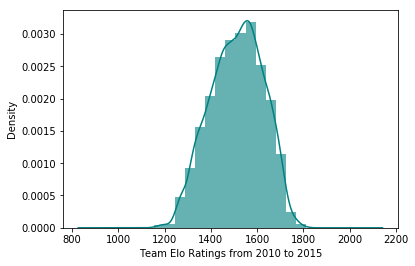

In [27]:
# Density graph of elo ratings from 2010 to 2015
ax = all_data1['elo_i'].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
all_data1['elo_i'].plot(kind='density', color='teal')
ax.set(xlabel='Team Elo Ratings from 2010 to 2015')
plt.show()

We now compare the elo ratings between teams in the 2010-2011 season, the 2011-2012 season, the 2012-2013 season, the 2013-2014 season, and the 2014-2015 season.  Note that the graphs below are based on both regular season data and playoff data.  Each of the histograms appear to be more or less normally distributed around a mean 1500.  This means that from 2010 to 2015 most NBA teams had an elo rating that was close to 1500.  We can also see from the graphs below that 2014-2015 was the only season where a team (or possibly multiple teams) reached an elo rating of 1800.   

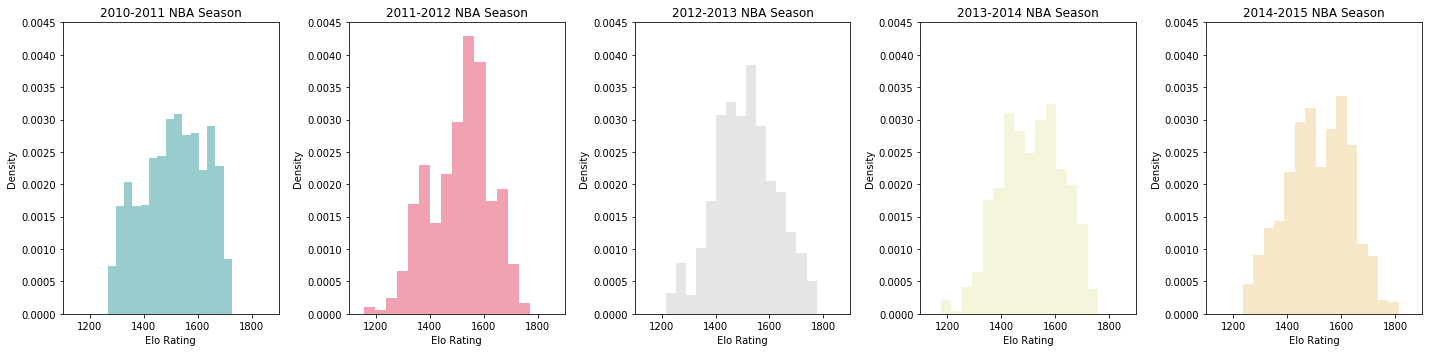

In [28]:
# Prepare data for graphs
elo_2010 = all_data1['elo_i'][all_data1['SEASON']==2010].reset_index(drop=True)
elo_2011 = all_data1['elo_i'][all_data1['SEASON']==2011].reset_index(drop=True)
elo_2012 = all_data1['elo_i'][all_data1['SEASON']==2012].reset_index(drop=True)
elo_2013 = all_data1['elo_i'][all_data1['SEASON']==2013].reset_index(drop=True)
elo_2014 = all_data1['elo_i'][all_data1['SEASON']==2014].reset_index(drop=True)

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].hist(elo_2010,bins=15, density=True, stacked=True, color='teal', alpha=0.4)
axes[0].set_xlabel('Elo Rating')
axes[0].set_ylabel('Density')
axes[0].set_xlim(1100,1900)
axes[0].set_ylim(0,.0045)
axes[0].set_title('2010-2011 NBA Season')
axes[1].hist(elo_2011,bins=15, density=True, stacked=True, color='crimson', alpha=0.4)
axes[1].set_xlabel('Elo Rating')
axes[1].set_ylabel('Density')
axes[1].set_xlim(1100,1900)
axes[1].set_ylim(0,.0045)
axes[1].set_title('2011-2012 NBA Season')
axes[2].hist(elo_2012,bins=15, density=True, stacked=True, color='silver', alpha=0.4)
axes[2].set_xlabel('Elo Rating')
axes[2].set_ylabel('Density')
axes[2].set_xlim(1100,1900)
axes[2].set_ylim(0,.0045)
axes[2].set_title('2012-2013 NBA Season')
axes[3].hist(elo_2013,bins=15, density=True, stacked=True, color='beige', alpha=1)
axes[3].set_xlabel('Elo Rating')
axes[3].set_ylabel('Density')
axes[3].set_xlim(1100,1900)
axes[3].set_ylim(0,.0045)
axes[3].set_title('2013-2014 NBA Season')
axes[4].hist(elo_2014,bins=15, density=True, stacked=True, color='wheat', alpha=0.7)
axes[4].set_xlabel('Elo Rating')
axes[4].set_ylabel('Density')
axes[4].set_xlim(1100,1900)
axes[4].set_ylim(0,.0045)
axes[4].set_title('2014-2015 NBA Season')
plt.tight_layout()
plt.show()

Below we sort the data by elo rating to find the highest elo rating achieved between 2010 and 2015.  It turns out that the team with an elo rating in the 1800's in the rightmost graph above was the 2014-2015 Golden State Warriors.  They achieved a peak elo rating of 1822.2881 in the 2014-2015 post-season.  We choose to sort the data by elo_n - elo rating after a game - instead or elo_i - elo rating before a game - in case the highest elo rating achieved from 2010 to 2015 was achieved after the final game of 2015 (it turns out it was!).  

Every elo rating a team had between 2010 and 2015 - besides the elo_i of their first game of 2010 - is listed in the elo_n column.  In order to confirm that 1822.2881 is the highest elo rating a team achieved from 2010 to 2015, we need to check that no team had an elo_i greater than 1822.2881 leading into their first game of 2010.  The leftmost graph above shows all elo_i ratings that teams had in the 2010-2011 season - clearly no team had an elo_i larger than 1822.2881 for any game that season much less for the first game.  Therefore, 1822.2881 is the highest elo rating a team achieved from 2010 to 2015.

In [29]:
# Sort from highest to lowest elo rating
all_data1.sort_values(by='elo_n',ascending=False).head(7)

,game_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,win_equiv,...,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,DATE_OBJECT_GAME_DATE_EST
12657,201506170CLE,06/16/2015,103,1,GSW,Warriors,105,1813.6349,1822.2881,68.519516,...,56.0,1.610613e+09,105.0,0.435,0.621,0.382,28.0,39.0,0.0,2015-06-16
12654,201506140GSW,06/14/2015,102,1,GSW,Warriors,104,1809.9791,1813.6349,68.013329,...,43.0,1.610613e+09,91.0,0.395,0.714,0.343,17.0,37.0,1.0,2015-06-14
12637,201505230HOU,05/23/2015,95,1,GSW,Warriors,115,1791.2300,1813.4543,68.002609,...,39.0,1.610613e+09,115.0,0.454,0.800,0.393,26.0,60.0,0.0,2015-05-23
12653,201506110CLE,06/11/2015,101,1,GSW,Warriors,103,1790.9591,1809.9791,67.794983,...,49.0,1.610613e+09,103.0,0.468,0.704,0.400,24.0,44.0,0.0,2015-06-11
12646,201506040GSW,06/04/2015,98,1,GSW,Warriors,108,1802.2509,1806.2035,67.566650,...,48.0,1.610613e+09,100.0,0.415,0.684,0.290,19.0,45.0,1.0,2015-06-04
12644,201505270GSW,05/27/2015,97,1,GSW,Warriors,104,1797.8933,1802.2509,67.324539,...,59.0,1.610613e+09,90.0,0.351,0.750,0.208,16.0,39.0,1.0,2015-05-27
12641,201505250HOU,05/25/2015,96,1,GSW,Warriors,115,1813.4543,1797.8933,67.053963,...,46.0,1.610613e+09,115.0,0.454,0.538,0.435,26.0,47.0,1.0,2015-05-25


Below we graph the elo ratings for the Mavs, the Heat, the Spurs, and the Warriors from the 2010-2011 season to the 2014-2015 season.  Each of these teams won at least one championship during this time.  We first notice that each line has four smooth sections.  These sections correspond to the off-season, when the elo ratings of NBA teams no longer change on a daily basis.

##### Interesting takeaways:
1. Each of the 4 teams seem to reach their highest or second highest elo rating around the time they win the championship.  This makes sense - as teams progress through the playoffs the competition becomes better, so elo ratings increase more after wins.  The two teams that reach the championship also play more games than teams that did not make the playoffs and teams that were eliminated in earlier rounds of the playoffs, so they have more opportunities to increase their elo rating.

    - The Mavs reach their highest elo rating after winning the 2010-2011 championship
    - The Heat reach their highest elo rating in the 2012-2013 playoffs that they won
    - The Spurs reach their second highest elo rating after winning the 2013-2014 championship
    - The Warriors reach their highest elo rating after winning the 2014-2015 championship
    
    
2. The Warriors's elo rating increases from the beginning of the 2012-2013 season until the time they win a championship.  The 2012-2013 season was the first season that Steph Curry, Draymond Green, and Klay Thompson played together.  The Warriors's success after the start of the 2012-2013 season likely has to do with the Curry, Green, and Thompson trio becoming more experienced and maturing.

3. The Heat's elo rating drops precipitously after the 2013-2014 season.  Undoubtedly, Lebron's departure from Miami in the summer of 2014 lead to this elo rating decline.

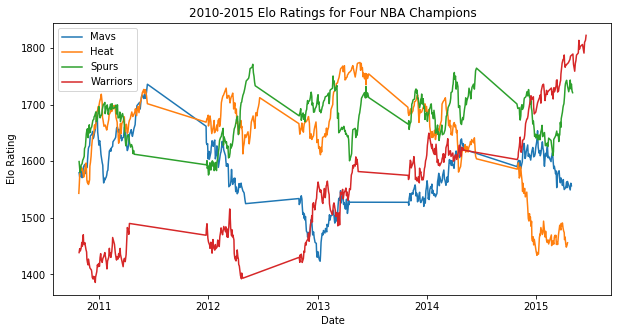

In [30]:
# Prepare mavs, heat, spurs, warriors data for graphing
mavs = all_data1[['elo_n','DATE_OBJECT_GAME_DATE_EST']][all_data1['team_id']=='DAL'].reset_index(drop=True)
heat = all_data1[['elo_n','DATE_OBJECT_GAME_DATE_EST']][all_data1['team_id']=='MIA'].reset_index(drop=True)
spurs = all_data1[['elo_n','DATE_OBJECT_GAME_DATE_EST']][all_data1['team_id']=='SAS'].reset_index(drop=True)
warriors = all_data1[['elo_n','DATE_OBJECT_GAME_DATE_EST']][all_data1['team_id']=='GSW'].reset_index(drop=True)

plt.rcParams['figure.figsize'] = (10,5)
plt.plot(mavs['DATE_OBJECT_GAME_DATE_EST'],mavs['elo_n'],label='Mavs')
plt.plot(heat['DATE_OBJECT_GAME_DATE_EST'],heat['elo_n'],label='Heat')
plt.plot(spurs['DATE_OBJECT_GAME_DATE_EST'],spurs['elo_n'],label='Spurs')
plt.plot(warriors['DATE_OBJECT_GAME_DATE_EST'],warriors['elo_n'],label='Warriors')
plt.xlabel('Date')
plt.ylabel('Elo Rating')
plt.title('2010-2015 Elo Ratings for Four NBA Champions')
plt.legend()
plt.show()

The all_data1 data currently has two rows for every game played - one for the home team and one for the away team.  We remove the duplicate rows in the cell below.

In [31]:
# Remove duplicate rows
all_data2 = all_data1[all_data1['home']=='H'].reset_index(drop=True)

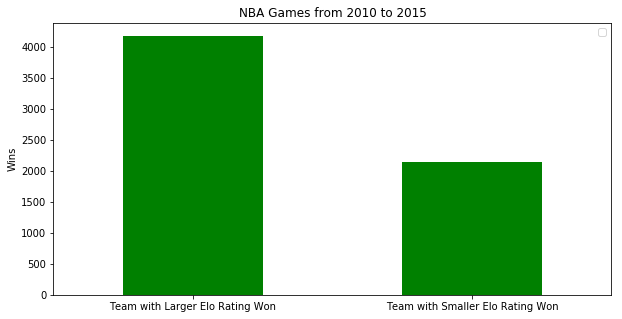

In [32]:
# Prepare data for graphing
all_data2['LorS_Elo_Win'] = all_data2.apply(lambda x: 'Team with Larger Elo Rating Won' 
                                            if (((x['elo_i'] > x['opp_elo_i']) & (x['HOME_TEAM_WINS']==1))
                                                | ((x['opp_elo_i'] > x['elo_i']) & (x['HOME_TEAM_WINS']==0)))
                                            else 'Team with Smaller Elo Rating Won',axis=1)

bar_plot = pd.DataFrame(all_data2.groupby(['LorS_Elo_Win'])['LorS_Elo_Win'].count())

bar_plot.plot.bar(color=['green','yellow'])
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend('')
plt.ylabel('Wins')
plt.title('NBA Games from 2010 to 2015')
plt.show()

In [33]:
# Create 10-game rolling average variables
all_data1 = all_data1.sort_values(by='DATE_OBJECT_GAME_DATE_EST')

df = pd.DataFrame()

for team in team_names2['TEAM_ABBREVIATION'].to_list():
    rolling_data = all_data1[all_data1['team_id']==team][['SEASON','team_id','game_id','home','pts','FG_PCT_home',
                                                         'FT_PCT_home','FG3_PCT_home','AST_home',
                                                         'REB_home','FG_PCT_away',
                                                         'FT_PCT_away','FG3_PCT_away','AST_away','REB_away']]

    rolling_data['fg_pct'] = rolling_data.apply(lambda x: x['FG_PCT_home'] if x['home']=='H' else x['FG_PCT_away'],axis=1)
    rolling_data['ft_pct'] = rolling_data.apply(lambda x: x['FT_PCT_home'] if x['home']=='H' else x['FT_PCT_away'],axis=1)
    rolling_data['fg3_pct'] = rolling_data.apply(lambda x: x['FG3_PCT_home'] if x['home']=='H' else x['FG3_PCT_away'],axis=1)    
    rolling_data['assists'] = rolling_data.apply(lambda x: x['AST_home'] if x['home']=='H' else x['AST_away'],axis=1)
    rolling_data['rebounds'] = rolling_data.apply(lambda x: x['REB_home'] if x['home']=='H' else x['REB_away'],axis=1)    
    
    rolling_data['pts_ave'] = rolling_data['pts'].rolling(10).mean().shift()
    rolling_data['fg_pct_ave'] = rolling_data['fg_pct'].rolling(10).mean().shift()  
    rolling_data['ft_pct_ave'] = rolling_data['ft_pct'].rolling(10).mean().shift() 
    rolling_data['fg3_pct_ave'] = rolling_data['fg3_pct'].rolling(10).mean().shift()
    rolling_data['assists_ave'] = rolling_data['assists'].rolling(10).mean().shift() 
    rolling_data['rebounds_ave'] = rolling_data['rebounds'].rolling(10).mean().shift() 
    rolling_data = rolling_data.drop(columns=['home','pts','FG_PCT_home',
                                                         'FT_PCT_home','FG3_PCT_home','AST_home',
                                                         'REB_home','FG_PCT_away',
                                                         'FT_PCT_away','FG3_PCT_away','AST_away','REB_away',
                                                         'fg_pct','ft_pct','fg3_pct','assists','rebounds'])
    
    df = df.append(rolling_data)
df = df.reset_index(drop=True)

In [34]:
# The first 10 rows are used to calculate rolling averages for the 11th row
# These 10 rows have null values in the rolling ave columns so we drop them
df1 = df[df.isnull().sum(axis=1)==0].reset_index(drop=True)

In [35]:
# Retain relevant variables
all_data3 = all_data2[['team_id','game_id','is_playoffs','elo_i','opp_elo_i','HOME_TEAM_WINS','opp_id']]

In [36]:
# Merge rolling average data for home team onto all_data2
all_data4 = pd.merge(all_data3,df1,how='left',left_on=['team_id','game_id'],right_on=['team_id','game_id'])
all_data5 = all_data4.rename(columns={'pts_ave':'home_pts_ave','fg_pct_ave':'home_fg_pct_ave','ft_pct_ave':'home_ft_pct_ave',
                                      'fg3_pct_ave':'home_fg3_pct_ave','assists_ave':'home_assists_ave',
                                     'rebounds_ave':'home_rebounds_ave'})
# Merge rolling average data for away team onto all_data2
all_data6 = pd.merge(all_data5,df1,how='left',left_on=['opp_id','game_id'],right_on=['team_id','game_id'])
all_data7 = all_data6.drop(columns=['team_id_y','opp_id','team_id_x','game_id','SEASON_x','SEASON_y']).rename(columns={'pts_ave':'away_pts_ave',
                                                               'fg_pct_ave':'away_fg_pct_ave','ft_pct_ave':'away_ft_pct_ave',
                                                               'fg3_pct_ave':'away_fg3_pct_ave','assists_ave':'away_assists_ave',
                                                               'rebounds_ave':'away_rebounds_ave'})

In [37]:
# Remove rows that correspond to one of a team's first 10 games in 2010 - these have null values
all_data8 = all_data7[all_data7.isnull().sum(axis=1)==0].reset_index(drop=True)

### 4. Train and Test Machine Learning Models

Below we randomly place 70% of the rows in our data in a training set and 30% in a testing set.  Then we fit a logistic regression model to the training set and test our model on the testing set.  We use the AUC metric to assess our model's predictive accuracy.

In [38]:
# Create training and testing data
features = all_data8.drop(columns=['HOME_TEAM_WINS'])
response = all_data8['HOME_TEAM_WINS']
x_train, x_test, y_train, y_test = train_test_split(features,response, test_size=.3,random_state=5)
log_model = LogisticRegression()
log_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Discussion on the AUC Metric:
The term "AUC" refers to the area under the ROC curve, or the orange curve in the graph below.  The ROC curve graphs a model's true positive rate against its false positive rate at different thresholds, and each point on the orange ROC curve corresponds to a different threshold (see section below for further discussion on thresholds).  The black curve represents a model that has no ability in predicting home team wins or away team wins.  We say that our model is good at predicting both home team wins and away team wins if the AUC, or area under the ROC curve, is close to 1. 

$\textbf{Question}$: Why do we use the AUC metric instead of the percentage of correctly predicted game outcomes to assess the accuracy of our model?

$\textbf{Answer}$: A high percentage of correctly predicted game outcomes does not necessarily mean that our model predicted both home team wins and away team wins well.  A high AUC score, on the other hand, indicates that our model accurately predicts when both home teams win and away teams win.

#### Additional Discussion on Thresholds:
For every game in our data set, our logistic regression model outputs a probability that the home team wins.  Lets say we arbitrarily set our threshold at .2 and our logistic regression model tells us that there is a .3 probability that team 1 beats team 2.  Since .3 > .2 we say that our model predicts that team 1 beats team 2.  Our model produces a different true positive rate and false positive rate depending on the threshold, and the AUC metric takes into account all thresholds in measuring a model's accuracy.

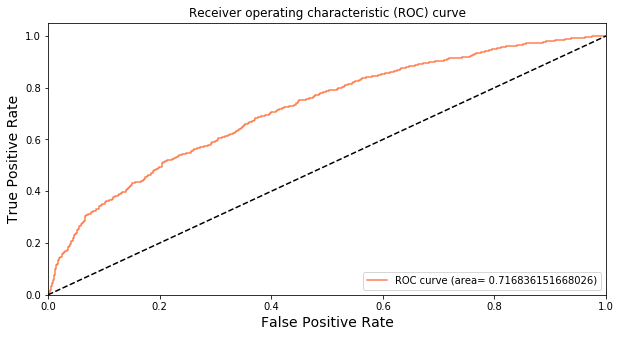

In [39]:
# Calculate predicted data
y_pred_log_proba = log_model.predict_proba(x_test)[:, 1]
# Calculate false positive rate and true positive rate at different thresholds
[fpr, tpr, thr] = roc_curve(y_test, y_pred_log_proba)

plt.figure()
plt.plot(fpr, tpr, color='coral',label='ROC curve (area= ' + str(auc(fpr,tpr))+')')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

The logistic regression model above used a L2 regularization term with a regularization penalty of 1.  The regularization term helps prevent our model from overfitting the training data by constraining the magnitudes of the coefficients of the model.  Below we try using different regularization parameters to improve our model's AUC score.  We use 10-fold cross validation to choose the best combination of regularization parameters for our model.  The 10-fold cross validation tells us that a logistic regression model with L2 regularization term and a regularization penalty of .5 fits the training data best.  When we run that model on the testing data we find an AUC of .716833, which is marginally smaller than AUC of the first logistic model we tried.  Interestingly, the model below fit the training data better than the logistic regression above but performed worse on the testing data. 

In [40]:
# Choose best hyperparameters for logistic regression model
penalty = ['l1','l2']
C = [.5,.75,1.0,1.25,1.5]
param_grid = {'penalty':penalty,'C':C}
log_grid_search = GridSearchCV(estimator = LogisticRegression(random_state=5),param_grid=param_grid,cv=10)
log_grid_search.fit(x_train,y_train)
print('Best hyperparameters: ' + str(log_grid_search.best_params_))
y_pred_logrid_proba = log_grid_search.predict_proba(x_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_logrid_proba)
print('AUC of Logistic Regression on Testing Data: ' + str(auc(fpr,tpr)))

Best hyperparameters: {'penalty': 'l2', 'C': 0.5}
AUC of Logistic Regression on Testing Data: 0.7168337459192486


We now compare a random forest's predictive capabilities to the first logistic regression model's predictive capabilities.  We first use 10-fold cross validation to choose hyperparameters for our model.  We experiment with different numbers of trees and different criteria for measuring the quality of splits in trees.  After choosing our hyperameters for our model and fitting the model (with those hyperamaters) on the training data, we then calculate an AUC of the random forest on the testing data.  The AUC of the Random Forest on the testing data is .691, so the Random Forest is worse at predicting the testing data then the first logistic regression model that had an AUC of .717.

In [41]:
# Choose best hyperparamters for logistic regression model
n_estimators = [25,50,75,100,125,150,175]
criterion = ['gini','entropy']
param_grid1 = {'n_estimators':n_estimators,'criterion':criterion}
rf_grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=5),param_grid=param_grid1,cv=10)
rf_grid_search.fit(x_train,y_train)
print('Best hyperparameters: ' + str(rf_grid_search.best_params_))
y_pred_rfgrid_proba = rf_grid_search.predict_proba(x_test)[:, 1]
[fpr1, tpr1, thr1] = roc_curve(y_test, y_pred_rfgrid_proba)
print('AUC of Random Forest on Testing Data: ' + str(auc(fpr1,tpr1)))

Best hyperparameters: {'n_estimators': 150, 'criterion': 'gini'}
AUC of Random Forest on Testing Data: 0.691470537997599


Now we check whether a the k-nearest neighbors algorithm can predict the testing data better than the first logistic regression model.  Again we use 10-fold cross validation to choose the hyperparameters that enable our model to perform best on the training data.  The results of the cross validation tell us that our model performs best on the training data when it uses 300 neighbors as opposed to 100, 200, 400, or 500 neighbors.  We proceed to fit a k-nearest model with 500 neighbors to the training data and test the model on the testing data.  The k-nearest neighbors model outperforms the logistic regression model with an AUC score of .718.

In [42]:
# Choose best hyperparameters for our model
n_neighbors = [100,200,300,400,500]
param_grid2 = {'n_neighbors':n_neighbors}
knn_grid_search = GridSearchCV(estimator = KNeighborsClassifier(),param_grid=param_grid2,cv=10)
knn_grid_search.fit(x_train,y_train)
print('Best hyperparameters: ' + str(knn_grid_search.best_params_))
y_pred_knngrid_proba = knn_grid_search.predict_proba(x_test)[:, 1]
[fpr2, tpr2, thr2] = roc_curve(y_test, y_pred_knngrid_proba)
print('AUC of k-nearest neighbors on Testing Data: ' + str(auc(fpr2,tpr2)))

Best hyperparameters: {'n_neighbors': 300}
AUC of k-nearest neighbors on Testing Data: 0.718276593748421


As mentioned above, most models that other data scientists used calculated NBA game outcomes with an accuracy between accuracy between 62% and 72%.  Below we see that the k-nearest neighbors model calculates NBA game outcomes with an accuracy of 66.7%.  Since our model's accuracy falls in the range of the other models' accuracies, our model performs well.

In [43]:
# Calculate accuracy of knn model
y_pred_knn = knn_grid_search.predict(x_test)
correct_pred = (y_pred_knn == y_test).sum()
total_pred = np.float(y_test.shape[0])

print('k-nearest neighbors accuracy: ' + str((correct_pred/total_pred)*100)+'%')

k-nearest neighbors accuracy: 66.70264436049649%


We now train and test our k-nearest neighbors model only on the playoffs data to see if we can achieve an accuracy near 74.4%.  As mentioned above, one data scientist predicted playoff games in the 2007-2008 playoffs with an accuracy of 74.4%.

In [44]:
# Calculate knn model accuracy of predicting playoff games
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_test_playoffs = x_test[x_test['is_playoffs'] == 1]
y_test_playoffs = y_test.iloc[x_test_playoffs.index]
y_pred_playoffs = knn_grid_search.predict(x_test_playoffs)

correct_playoff_pred = (y_pred_playoffs == y_test_playoffs).sum()
total_playoff_pred = np.float(y_test_playoffs.shape[0])

print('k-nearest neighbors playoff accuracy: ' + str((correct_playoff_pred/total_playoff_pred)*100)+'%')

k-nearest neighbors playoff accuracy: 60.33057851239669%


In [45]:
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_test_reg = x_test[x_test['is_playoffs'] == 0]
y_test_reg = y_test.iloc[x_test_reg.index]
y_pred_reg = knn_grid_search.predict(x_test_reg)

correct_reg_pred = (y_pred_reg == y_test_reg).sum()
total_reg_pred = np.float(y_test_reg.shape[0])

print('k-nearest neighbors playoff accuracy: ' + str((correct_reg_pred/total_reg_pred)*100)+'%')

k-nearest neighbors playoff accuracy: 67.14780600461894%


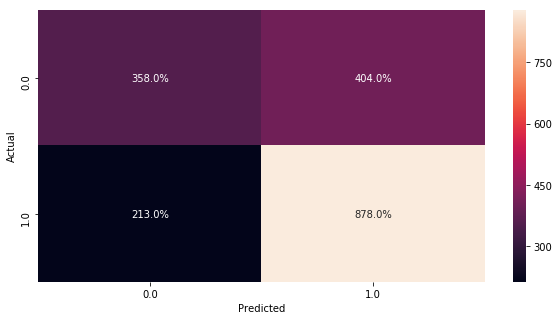

In [46]:
y_pred_knn = knn_grid_search.predict(x_test)
confusion_matrix = pd.DataFrame()
confusion_matrix['Actual'] = y_test
confusion_matrix['Predicted'] = y_pred_knn
confusion_matrix1 = pd.crosstab(confusion_matrix['Actual'],confusion_matrix['Predicted'],rownames=['Actual'],colnames=['Predicted'])
ax = sns.heatmap(confusion_matrix1,annot=True,fmt='.1f')
for t in ax.texts: t.set_text(t.get_text() + '%')
plt.show()

In [47]:
# See if playoff prediction increases
# Compare to the 74.4%